In [14]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from sklearn.cross_validation import train_test_split
import tqdm
%matplotlib inline

In [3]:
# класс one-hot encoder'а для MNIST
class OneHotEncoder:
    def __init__(self):
        self.transform_mapping = np.zeros((10,10))
        for i in range(self.transform_mapping.shape[0]):
            self.transform_mapping[i][i] = 1.0
    def transform(self, y):
        return self.transform_mapping[int(y)]

In [4]:
def make_submission(X_test, net, fname="my_submission.csv"):
    with open(fname,'w') as fout:
        fout.write('Id,Category')
        for i in range(X_test.shape[0]):
            y_h = net.forward(X_test[i])
            y = np.argmax(y_h)
            fout.write("\n{},{}".format(i, int(y)))

In [5]:
# внимание, тут Y_test в обычном формате(не onehot)
def compute_acc(X_test, Y_test, net):
    acc = 0.0
    for i in range(X_test.shape[0]):
        y_h = net.forward(X_test[i])
        y = np.argmax(y_h)
        if(y == np.argmax(Y_test[i])):
            acc += 1.0
    return acc / Y_test.shape[0]

In [6]:
train_data = None
test_data = None
encoder = OneHotEncoder()
with open('data_train.pickle','rb') as fin:
    train_data = pickle.load(fin)
with open('data_test_no_labels.pickle','rb') as fin:
    test_data = pickle.load(fin)
    
X_train = train_data['data']
Y_train = train_data['target']
Y_train_oh = np.array(list(map(lambda x : encoder.transform(x), Y_train)))

X_test = test_data['data']
print(X_test.shape[0])

17500


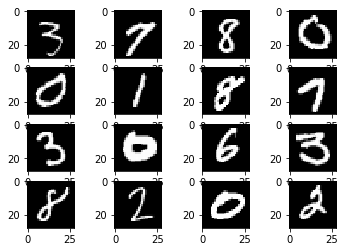

In [7]:
n=4
for i in range(n*n):
    plt.subplot(n,n,i+1)
    I = train_data['data'][np.random.randint(0, X_train.shape[0]),:]
    I = I.reshape((28, 28))
    plt.imshow(I, cmap='gray')

In [13]:
# Подготовка датасета
X_train = X_train.astype('float')
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)
X_train = (X_train - mean) / (std + 0.01)

In [9]:
# Определение слоев сети
# Dense:
class Dense:
    def __init__(self, in_size, out_size, rlambda = 0.0):
        self.W = np.random.normal(scale=0.01, size=(out_size, in_size)) * np.sqrt(2/(out_size + in_size))
        self.b = np.zeros(out_size)
        self.rlambda = rlambda
        
    def forward(self, x):
        self.x = x # запоминаем для обратного прохода
        return np.dot(self.W, x) + self.b
    
    def get_reg_loss(self):
        return 0.5 * self.rlambda * (np.linalg.norm(self.W, ord='fro') ** 2)
    
    def backward(self, dz, lr=0.001):
        # вычисляем градиенты по параметрам (запоминаем их для отладки)
        self.dW = np.outer(dz, self.x)
        self.db = dz
        # вычисляем производную по входу
        self.dx = np.matmul(dz, self.W) 
        # рассчитываем градиенты от регуляризатора
        if(self.rlambda != 0):
            self.dW += self.rlambda * self.W
        # обновляем веса
        self.W = self.W - lr * self.dW
        self.b = self.b - lr * self.db
        # возвращаем dx для продолжения алгоритма
        return self.dx

# ReLu:
class Max:
    
    def forward(self, x):
        self.x = x
        return np.maximum(0, x)
    
    def backward(self, dz, lr=0.001):
        dz[self.x < 0] = 0
        return dz
    
# Softmax:
class Softmax:
    
    def forward(self, x):
        x = x - np.max(x)
        self.x = x
        exps = np.exp(x)
        return exps / np.sum(exps)
    
    def backward(self, dz, lr=0.001):
        soft_max = self.forward(self.x)
        self.grad_softmax = soft_max * (np.eye(soft_max.shape[0], soft_max.shape[0]) - soft_max).T
        return np.dot(dz, self.grad_softmax)
    
# CrossEntropy:
class CrossEntropy:
    
    def forward(self, y_true, y_hat):
        self.yt = y_true
        self.yh = y_hat
        return -np.sum(y_true * np.log(y_hat))
    
    def backward(self, dz, lr=0.001):
        return (-1) * dz * self.yt.astype('float') / self.yh

# Dropout:
class Dropout:
    def __init__(self, p = 0.5):
        self.p = p
        self.train = True
    
    def set_train(self, train = True):
        self.train = train
    
    def forward(self, x):
        if not self.train:
            self.mask = np.ones(*x.shape)
            return x
        self.mask = ( np.random.rand(*x.shape) > self.p ) / (1.0 - self.p)
        return x * self.mask
        
    def backward(self, dz, lr=0.001):
        return dz * self.mask

In [10]:
# Опеределение самой сети
# MnistNet:
class MnistNet:
    
    def __init__(self, rlambda=0.0):
        self.drop1 = Dropout()
        self.d1 = Dense(784, 150, rlambda)
        self.m = Max()
        self.drop2 = Dropout()
        self.d2 = Dense(150, 10, rlambda)
        self.s = Softmax()
    
    def forward(self, x):
        net = self.drop1.forward(x)
        net = self.d1.forward(net)
        net = self.m.forward(net)
        net = self.drop2.forward(net)
        net = self.d2.forward(net)        
        net = self.s.forward(net)
        return net
    
    def backward(self, dz, lr):
        dz = self.s.backward(dz, lr)
        dz = self.d2.backward(dz, lr)
        dz = self.drop2.backward(dz, lr)        
        dz = self.m.backward(dz, lr)
        dz = self.d1.backward(dz, lr)
        dz = self.drop1.backward(dz, lr)
        return dz

In [11]:
# Здесь процедура обучения
net = MnistNet(0.0002)
net.drop1.p = 0.5
net.drop2.p = 0.01
loss = CrossEntropy()
lr = 0.00195
L_train = []
L_test = []
Acc = []
for epoch in tqdm.tqdm_notebook(range(15)):
    x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train_oh, test_size=0.33333, random_state=40)
    L_acc = 0.
    sh = list(range(x_train.shape[0]))
    np.random.shuffle(sh)
    net.drop1.train = True # включаем Dropout для train
    net.drop2.train = True
    for i in range(x_train.shape[0]):
        x = x_train[sh[i]]
        y = y_train[sh[i]]
        y_h = net.forward(x)
        L = loss.forward(y, y_h)
        L_acc += L 
        dz = loss.backward(1, lr)
        dz = net.backward(dz, lr)
    L_acc /= y_train.shape[0]
    L_train.append(L_acc)
    L_e_acc = 0.
    net.drop1.train = False # выключаем Dropout для test
    net.drop2.train = False
    for i in range(y_test.shape[0]):
        x = x_test[i]
        y = y_test[i]
        y_h = net.forward(x)
        L = loss.forward(y, y_h)
        L_e_acc += L
    L_e_acc /= y_test.shape[0]
    L_test.append(L_e_acc)
    Acc.append(compute_acc(x_test, y_test, net))
    print("{} epoch loss. Train : {} . Test : {}".format(epoch, L_acc, L_e_acc))
print("Accuracy: %.2f" % (100*Acc[-1]))

0 epoch loss. Train : 0.5966355880044628 . Test : 0.2626837443014489
1 epoch loss. Train : 0.31126511359898973 . Test : 0.18707330537507091
2 epoch loss. Train : 0.23740756407103644 . Test : 0.16052401149679918
3 epoch loss. Train : 0.2274864689394362 . Test : 0.1457788679829698
4 epoch loss. Train : 0.19372622205721352 . Test : 0.13614525632221747
5 epoch loss. Train : 0.19146137123989437 . Test : 0.1304074249714511
6 epoch loss. Train : 0.17756902270281613 . Test : 0.11844280592024367
7 epoch loss. Train : 0.15650160699338675 . Test : 0.1519392668591902
8 epoch loss. Train : 0.17409419547506116 . Test : 0.1269672219582338
9 epoch loss. Train : 0.16264331093673348 . Test : 0.12051462842257682
10 epoch loss. Train : 0.14767765485202444 . Test : 0.11643470697407825
11 epoch loss. Train : 0.1479068025534784 . Test : 0.10793121496144809
12 epoch loss. Train : 0.14053115072784908 . Test : 0.10802618907684315
13 epoch loss. Train : 0.1360795069554533 . Test : 0.11210340309541272
14 epoch lo

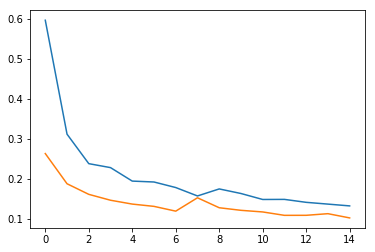

In [12]:
# Здесь необходимо отрисовать графики CrossEntropyLoss для обучающей и валидационной выборок
plt.plot(L_train, label='train')
plt.plot(L_test, label='test')

In [ ]:
# формируем сабмишшен и заливаем его на kaggle
X_test = X_test.astype('float')
mean = np.mean(X_test, axis=0)
std = np.std(X_test, axis=0)
X_test_norm = (X_test - mean) / (std + 0.01)

make_submission(X_test_norm, net)